# Presentation On Ant Colony Optimization (ACO)

Isaac Hawn

$\textbf{Abstract}$

Ant Colony Optimization or ACO represents a recent emerging field in mathematics and has broad implications across different mathematical areas, specifically the in the area of pathfinding optimization. As motivation, consider the problem of mail delivery. In Illinois alone, there are $1367$ cities [2] meaning that there are $1367! \approx 7.62e3694$ possible paths between all of them. Calculating the optimal path between all these nodes is impossible in practice using conventional means. However, by mimicking the way that ants forage for food, we can drastically simplify this problem. Following is a brief overview of ACO, including its algorithms as well as how it is implemented programically. For the latter, we will be using the AntColony.jl library.

$\textbf{Biological Overview}$

Let there exist an ant nest and a food source some distance away. Further, let there be two different paths connecting these two places. We will denote these paths $A$ and $B$. Due to the terrain, path $A$ is shorter than path $B$. Ants in the nest detect the food source and begin traveling to it. The path that they elect to travel on is selected at random since no ant has been to this food source yet. Ants traveling on path $A$ reach the food source first and return to the colony along the same path. All ants involved are continuously laying down pheromones as they walk. Thus, as path $A$ ants return first, other ants at the nest detect the fresh pheromones along path $A$ and choose this path to travel to the food source. Ants in path $B$ return eventually but since it took them longer, their pheromone path is weaker due to evaporation. This combines with the fact that new ants on path $A$ are already laying down pheromones and results in all ants eventually taking the shortest path to the food - path $A$.

$\textbf{Algorithm Overview}$

Before discussing the algorithms involved in computing ACO solutions, several variables need to be defined:

$$\begin{cases} \tau_0 = \text{ initial pheromone value} \\
\tau_{ij} = \text{ pheromone density on path from i to j} \\
\rho = \text{ pheromone evaporation rate} \\
\alpha = \text{ pheromone release rate} \\
\beta = \text{ ant visiblility} \\
d = \text{ distance from i to j} \\
\eta_{ij} = \frac{1}{d_{ij}} \\
m = \text{ number of ants} \end{cases}$$

$\textbf{The Ant System Algorithm (AS)}$

AS represents the first proposed aco algorithm. Its general steps are as follows: Define some sort of stopping condition, usually iteration count. Then each iteration, construct ant solutions by having $m$ ants traverse the graph. In the first iteration, their paths are chosen randomly. In subsequent iterations however, ants will pick their paths according to the following probability:

$$p^k_{ij}(t) = \begin{cases} \frac{[t_{ij}(t)]^\alpha \cdot [\eta_{ij}]^\beta}{\sum_{k\in P} [\tau_{ik} (t)]^\alpha \cdot [\eta_{ik}]^\beta} \text{, } j \in P \\ 0 \text{, else} \end{cases} \text{ [6]}$$

Essentially, this represents the probability that ant $k$ will go from city $i$ to city $j$. $M$ represents the set of cities not yet traveled to by ant $k$. In the next step, update the pheromone values along each path like so:

$$\tau_{ij} (t + n) = (1 - \rho) \tau_{ij} (t) + \sum_{k = 1}^m \Delta \tau^k_{ij} \text{ [4]}$$

$\Delta \tau^k_{ij}$ represents the amound of pheromone layed down by ant $k$ along edge $ij$. This value is computed by the following:

$$\Delta \tau^k_{ij} = \begin{cases} \frac{Q}{L_k} \text{, if ant } k \text{ traversed edge } ij \text{ during timestep } t + n \\0 \text{, else} \end{cases} [4]$$

where $L_k$ represents total path length for ant $k$ during the current iteration and $Q$ is some constant. At the end of the last iteration, the solution will be the path with the highest pheromone concentration. Programmatically, we would store the pheromone levels in matrix $\tau$.

$\textbf{Elitist Ant System}$

This algorithm is similar to AS except only the ant with the best solution that iteration lays down a pheromone trail.

$\textbf{Max-Min Ant Systems (MMAS)}$

The AS algorithm is a good starting point but it has a couple of issues, the main one being that the algorithm may converge to a local solution not equal to the global solution. This issue is magnified on problems with a large scale. The MMAS algorithm aims to fix this flaw by only allowing the ant with the shortest path on a given iteration to update the pheromone trail. Further, this pheromone update will be bounded between $\tau_\min$ and $\tau_\max$. Usually, $\tau_0 = \tau_\max$. Mathematically, MMAS is the same as AC except the pheromone update step will look like the following:

$$\tau_{ij} (t + n) = {\Big[(1 - \rho) \cdot \tau_{ij}(t) + \Delta \tau^\ell_{ij}\Big]}^{\tau_\max}_{\tau_\min} \text{ [4]}$$

Notice that instead of using the sum of all pheromones released on edge $ij$ this step only incorporates the amount of pheromones released by the ant with the current best path, ant $\ell$. We define the amount of pheromones layed down by this ant as:

$$\tau^\ell_{ij} = \begin{cases} \frac{1}{L_\ell} \text{, if edge } ij \text{ lies on ant } \ell \text{'s path} \\ 0 \text{, else} \end{cases} \text{ [4]}$$

Note that $\tau_\min$ and $\tau_\max$ are problem specific.


$\textbf{AntColony.jl}$

The Julia implementation of ACO, AntColony.jl, incorporates elements from all the above algorithms and it has several notable features. Firstly, ants use a "roulette style" selection, meaning that edges with less pheromone concentration have less chance of being selected but still may be selected. This drastically reduces the chance of converging to a local solution prematurely. Secondly, just as in the Elitist Ant System, only the ant which found the best path in a given iteration will lay down pheromones.

$\textbf{The Problem}$

As alluded to earlier, we will be finding the minimum distance between cities for the purpose of optimizing mail delivery. For simplicity, we will be generating a fictional region with a random spread of cities.

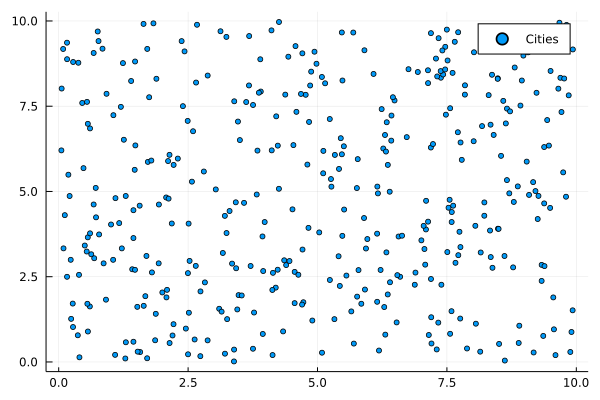

In [26]:
using Plots

function Distance_Formula(a, b)
   return sqrt((a[1] - b[1])^2 + (a[2] - b[2])^2) 
end

function Generate_ACO_Problem(_cityCount, regionBounds, maxDistVar)
    
    _cities = zeros(_cityCount,2) #array to store city locations
    
    #Generate city locations
    for i = 1:_cityCount
        _cities[i,1] = rand()*regionBounds[1]
        _cities[i,2] = rand()*regionBounds[1]   
    end

    
    distanceMtx = zeros(_cityCount, _cityCount)   #Matrix representation of distance between cities.
                                                  #For example, entry 2,4 would be the distance between city 2 and city 4
    
    for i = 1:_cityCount
        for j = 1:_cityCount
            #Store the distance between cities plus some random value to account for terrain.
            #AntColony.jl workes with directed graphs meaning that the route from A to B could
            #be different from B to A
            if i == j
                distanceMtx[i,j] = 0
            else
                distanceMtx[i,j] = Distance_Formula(_cities[i, :], _cities[j, :]) + maxDistVar*rand()
            end
        end
    end

    return distanceMtx, _cities
end

bounds = [10,10]
cityCount = 400
maxDistanceVariation = 0


acoProb = Generate_ACO_Problem(cityCount, bounds, maxDistanceVariation)
distMtx = acoProb[1]
cities = acoProb[2]

scatter(cities[:, 1], cities[:, 2], label = "Cities",  markersize = 3)

Better solution found with cost 198.99207826585007 at iteration 1
Better solution found with cost 197.3514749977518 at iteration 2
Better solution found with cost 190.04982400815297 at iteration 3
Better solution found with cost 188.7699842103545 at iteration 10
[3, 347, 74, 282, 29, 173, 280, 294, 186, 21, 368, 134, 376, 106, 298, 355, 279, 364, 81, 289, 47, 142, 209, 335, 361, 119, 187, 271, 23, 211, 165, 160, 324, 381, 386, 199, 285, 341, 90, 336, 135, 178, 251, 268, 168, 40, 11, 352, 306, 369, 17, 128, 232, 238, 202, 373, 60, 28, 339, 322, 48, 58, 313, 281, 54, 252, 269, 26, 150, 188, 129, 182, 358, 84, 212, 192, 15, 163, 307, 233, 256, 222, 124, 115, 245, 317, 393, 375, 195, 261, 394, 239, 216, 274, 204, 70, 230, 374, 241, 170, 64, 250, 220, 291, 207, 293, 8, 65, 138, 300, 272, 137, 175, 30, 320, 156, 357, 328, 37, 378, 105, 362, 116, 193, 288, 226, 248, 167, 35, 287, 311, 206, 303, 243, 98, 382, 189, 99, 197, 51, 153, 304, 147, 258, 32, 214, 86, 240, 5, 387, 25, 325, 337, 158, 38

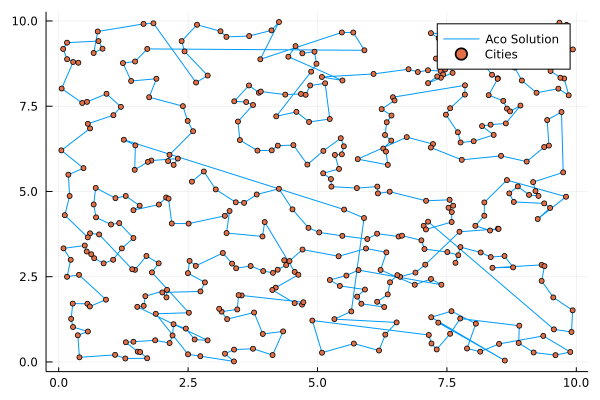

In [27]:
using AntColony


acoSolution = aco(distMtx, start_node = 3, end_node = 2, verbose = true) #Solve using ACO
print(acoSolution, "\n\n")

#Order city array according to aco solution for plotting purposes
temp = zeros(cityCount, 2)
for i = 1:cityCount
    temp[i,:] = cities[acoSolution[i],:]
end
cities = temp

plot(cities[:, 1], cities[:, 2], label = "Aco Solution")
scatter!(cities[:, 1], cities[:, 2], label = "Cities", markersize = 3)

$\textbf{Algorithm Speed}$

Following is a short benchmark to visualize the relationship between number of nodes and problem difficulty. The Dantzig-Fulkerson-Johnson is also tested for comparison

In [ ]:
using TravelingSalesmanExact, GLPK


#Dantzig-Fulkerson-Johnson
#Github test code
function Gen_Solve_DFJ(size)
    set_default_optimizer!(GLPK.Optimizer)

    cities = [ 100*rand(2) for _ in 1:size];
    return @elapsed tour, cost = get_optimal_tour(cities; verbose = false)
end

#Ant Colony Optimization
function Gen_Solve_ACO(size)
    cityCount = size
    maxDistanceVariation = 0

    acoProb = Generate_ACO_Problem(cityCount, bounds, maxDistanceVariation)
    print("\n\n",acoProb[1])
    distMtx = acoProb[1]
    cities = acoProb[2]
    
    return @elapsed aco(distMtx, start_node = 1, end_node = 2, verbose = false, max_iter = 20)
end

#Averaged execution time
function Ave_Cycles(n, f, _size)
    sum = 0
    for i = 1:n
        sum += f(_size)
    end
    return sum/n
end

#Main bench function
function Bench(MaxSize, cyclesPerIt)
    
    bounds = [10,10]
    dfj_times = zeros(MaxSize - 2)
    aco_times = zeros(MaxSize - 2)
    
    for i = 3:MaxSize
        dfj_times[i - 2] = Ave_Cycles(cyclesPerIt, Gen_Solve_DFJ, i)
        
        
        aco_times[i - 2] = Ave_Cycles(cyclesPerIt, Gen_Solve_ACO, i)
    end
    
    return dfj_times,aco_times
end

benchResults = Bench(75, 5)

dfj_t = benchResults[1]
aco_t = benchResults[2]

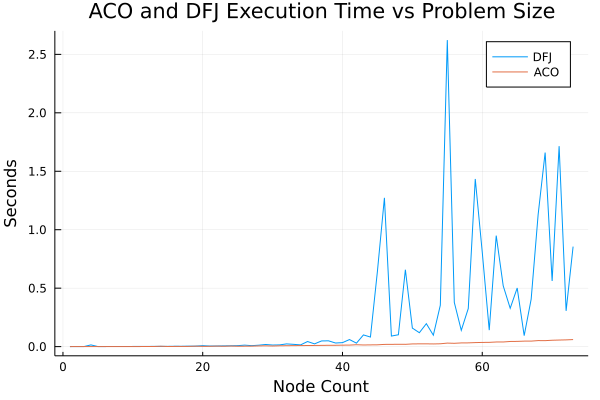

In [24]:
plot(dfj_t, xlabel = "Node Count", ylabel = "Seconds", title = "ACO and DFJ Execution Time vs Problem Size", label = "DFJ")
plot!(aco_t, label = "ACO")

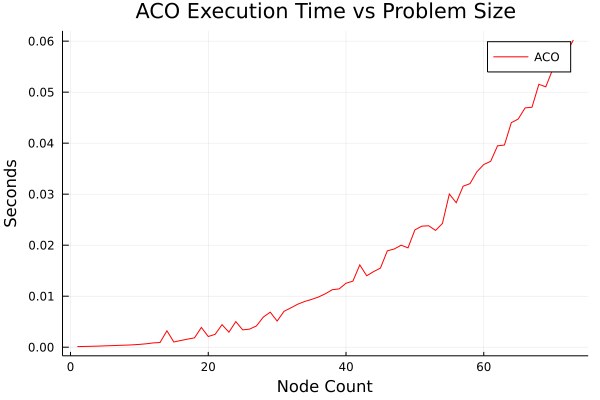

In [25]:
plot(aco_t, label = "ACO", color = "red", title = "ACO Execution Time vs Problem Size",xlabel = "Node Count", ylabel = "Seconds",)

$\textbf{AntColony.jl Source Code}$

Finally, we will be looking into the source code of AntColony.jl to tie some similarities to the algorithms discussed. The following is from the github page linked in the sources. 

In [ ]:
#Source code of AntColony.jl taken from GitHub

module AntColony

export aco

using Statistics


function aco(
        dist_mat::AbstractMatrix{<:Number};
        start_node::Union{Nothing, Int} = nothing,
        end_node::Union{Nothing, Int} = nothing,
        is_tour = false,
        beta = 2,
        rho = 0.1,
        q = 0.1,
        Q = 1.0,
        tau_min = 1.0,
        tau_max = 10.0,
        max_iter = 20,
        reset_iter = 10,
        top_perc_ants = 0.05,
        verbose = false
    )

    @assert isnothing(start_node) && isnothing(end_node) || !isnothing(start_node) && !isnothing(end_node)
    @assert if is_tour && (!isnothing(start_node) || !isnothing(end_node)); start_node != end_node else true end

    _, n_nodes = size(dist_mat)
    ants = trunc(Int, n_nodes) #set ant count to number of nodes
    top_k_ants = max(1, trunc(Int, top_perc_ants * ants))

    # how many factors an edge is better than the expected edge (median) to that node
    η = (median(dist_mat, dims=1)' ./ dist_mat) .^ beta
    τ = fill(tau_max, n_nodes, n_nodes) #Set tau to tau_max

    no_improv = 0
    best_path = nothing
    best_cost = Inf

    for i in 1:max_iter
        # probability matrix for the ants decision making
        P = τ .* η
        solutions = []
        _start_node, _end_node = start_node, end_node

        for _ in 1:ants
            # select random start/end nodes
            if isnothing(start_node)
                _start_node = rand(1:n_nodes)
                if is_tour
                    _end_node = _start_node
                end
            end
            path = travel(P, q, _start_node, _end_node)
            cost = sum(edge_distances(dist_mat, path, is_tour))
            push!(solutions, (cost, path))
        end

        # update if better solution found
        sort!(solutions)
        best_local_cost, best_local_path = solutions[1]
        if best_local_cost < best_cost #shorter path found
            if verbose
                println("Better solution found with cost $(best_local_cost) at iteration $(i)")
            end
            best_path = best_local_path
            best_cost = best_local_cost
            no_improv = 0
        else
            no_improv += 1
        end

        # deposit pheromones
        for (cost, path) in solutions[1:top_k_ants]
            Δτ = Q / cost #From AS
            for (from, to) in edges(path, is_tour)
                τ[to, from] += Δτ
            end
        end

        # reset when stagnation
        if no_improv > reset_iter
            no_improv = 0
            τ = fill(tau_max, n_nodes, n_nodes)
        else
            # evaporate pheromones
            τ = max.(tau_min, min.(tau_max, τ * (1 - rho)))
        end

    end

    best_path
end


"""
    travel(P, q, start_node, end_node)
Travel through graph based on probability `P`
"""
function travel(
        P::Matrix{<:Number},
        q::Float64,
        start_node::Int,
        end_node::Union{Nothing, Int} = nothing
    )

    not_visited = trues(size(P)[1])
    n_nodes = count(not_visited)
    not_visited[start_node] = false
    if !isnothing(end_node)
        not_visited[end_node] = false
    end
    path = Array{Int}(undef, n_nodes)
    path[1] = start_node

    node = start_node

    for i in 2:n_nodes
        if i == n_nodes && !isnothing(end_node) && start_node != end_node
            not_visited[end_node] = true
        end

        neighbor_idx = if rand() < q
            sample(1:count(not_visited), P[not_visited, node])
        else
            argmax(P[not_visited, node])
        end
        next_node = findall(not_visited)[neighbor_idx]

        not_visited[next_node] = false
        path[i] = next_node
        node = next_node
    end
    path
end


"""
    edges(path, is_tour)
Generate node pairs representing edges in `path`
"""
function edges(path::AbstractArray{Int}, is_tour::Bool)
    path_len = length(path)
    n_edges = if is_tour path_len else path_len - 1 end
    (
        (path[i], path[mod1(i + 1, path_len)])
        for i in 1:n_edges
    )
end


"""
    edge_distances(dist_mat, path, is_tour)
Generate a distances for each edge in `path`
"""
function edge_distances(
        dist_mat::AbstractMatrix{<:Number},
        path::AbstractArray{Int},
        is_tour::Bool
    )
    (dist_mat[to, from] for (from, to) in edges(path, is_tour))
end


"""
    sample(x, weights)
Sample from `x` with a custom distribution defined by `weights`
"""
function sample(x, weights)
    ecdf = cumsum(weights)
    p = rand() * ecdf[end]
    for i in 1:length(ecdf)
        if p <= ecdf[i]
            return x[i]
        end
    end
end


end

Sources:

[1] Ericphanson. “Ericphanson/TravelingSalesmanExact.jl.” GitHub, github.com/ericphanson/TravelingSalesmanExact.jl.

[2] “Illinois Cities by Population.” Illinois Outline, www.illinois-demographics.com/cities_by_population.

[3] JAD, 2006/2007. “Navigation.” Newcastle Engineering Design Centre, www.edc.ncl.ac.uk/highlight/rhjanuary2007g02.php.

[4] M. Dorigo, M. Birattari and T. Stutzle, "Ant colony optimization," in IEEE Computational Intelligence Magazine, vol. 1,        no. 4, pp. 28-39, Nov. 2006, doi: 10.1109/MCI.2006.329691.

[5] Schiegl. “Schiegl/AntColony.jl.” GitHub, github.com/schiegl/AntColony.jl.

[6] Y. Oonsrikaw and A. Thammano, "Enhanced Ant Colony Optimization with Local Search," 2018 IEEE/ACIS 17th International          Conference on Computer and Information Science (ICIS), 2018, pp. 291-296, doi: 10.1109/ICIS.2018.8466388.